In [3]:
from IPython.display import HTML

HTML("""<style>
.lev1 {margin-left: 80px}
.lev2 {margin-left: 100px}
.lev3 {margin-left: 120px}
.lev4 {margin-left: 140px}
.lev5 {margin-left: 160px}
.lev6 {margin-left: 180px}
</style>""")

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing the data</a></div><div class="lev2 toc-item"><a href="#Loading-and-cleaning-the-full-dataset:" data-toc-modified-id="Loading-and-cleaning-the-full-dataset:-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading and cleaning the full dataset:</a></div><div class="lev2 toc-item"><a href="#Preparing-the-time-series" data-toc-modified-id="Preparing-the-time-series-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Preparing the time-series</a></div><div class="lev3 toc-item"><a href="#overall--broad-distribution-of-#-events/runner" data-toc-modified-id="overall--broad-distribution-of-#-events/runner-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>overall  broad distribution of # events/runner</a></div><div class="lev3 toc-item"><a href="#summary-of-distances-popularity" data-toc-modified-id="summary-of-distances-popularity-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>summary of distances popularity</a></div><div class="lev3 toc-item"><a href="#only-marathon-runners" data-toc-modified-id="only-marathon-runners-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>only marathon runners</a></div><div class="lev3 toc-item"><a href="#only-semi-marathon-runners" data-toc-modified-id="only-semi-marathon-runners-124"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>only semi-marathon runners</a></div><div class="lev3 toc-item"><a href="#only-10-Km-runners" data-toc-modified-id="only-10-Km-runners-125"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>only 10 Km runners</a></div><div class="lev1 toc-item"><a href="#Clustering-of-time-series" data-toc-modified-id="Clustering-of-time-series-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clustering of time-series</a></div><div class="lev2 toc-item"><a href="#exploration-of-ts" data-toc-modified-id="exploration-of-ts-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>exploration of ts</a></div><div class="lev2 toc-item"><a href="#define-DTW-distance" data-toc-modified-id="define-DTW-distance-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>define DTW distance</a></div><div class="lev2 toc-item"><a href="#DTW-for-10-Km-time-series" data-toc-modified-id="DTW-for-10-Km-time-series-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DTW for 10 Km time-series</a></div>

<center><big><b>
 Clustering professional/non-professional on the full Datasport dataset
</b></big></center>

<center>
In this notebook we will also use <i> unsupervised </i> learning techniques to try to distinguish 
<i> professional runner, from non-professional ones. </i>   

More generally, we look for any signature of such distinction that could come from  the features present in our dataset.
</center>

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import powerlaw 
import itertools as itt

# Preparing the data

## Loading and cleaning the full dataset:

In [61]:
full_df = pd.read_pickle('../../df_userID.pickle')

#  removing useless features
full_df.drop(['MinTemp','MaxTemp','Weather',
              'LivingPlace','Rank','Category','Name',
              'RaceMonth','RaceID','Place'],axis=1,inplace=True)

global data transformations:

In [62]:
# in order to plot age (@time of the event!) instead of year of birth
full_df['age'] = full_df.RaceYear - full_df.Year

# parsing race Date  string - we don't care about the day of the week
full_df.Date = [d[5:] for d in full_df.Date]
# converting Date string to  datetime object
full_df.Date = [datetime.datetime.strptime(d,'%d.%m.%Y') for d in full_df.Date] 

# RaceYear and Year were needed only to compute the runner's age  AT THE year of the events 
full_df.drop('Year',axis=1,inplace=True)
full_df.drop('RaceYear',axis=1,inplace=True)

# Round `Distance` feature:
full_df.Distance = full_df.Distance.round()
full_df.Distance = full_df.Distance.astype('int')

# transform timedelta in minutes!
full_df.Time = full_df.Time.astype('timedelta64[m]')

# transform Pace timedelta in minutes - mind that numbers are  in decimal and NOT in Sexagesimal!
full_df.Pace = round(full_df.Pace.astype('timedelta64[s]')/60.0,2)

# these 2 are actually the same event!
full_df.Race = full_df.Race.apply(
    lambda x: 'Lucerne Marathon, Luzern' if x == 'SwissCityMarathon - Lucerne, Luzern' else x
)

In [63]:
full_df.head()

,Race,Date,Distance,Sex,Time,Pace,UserID,age
0,Kerzerslauf,2000-03-18,15,M,62.0,4.15,Abgottspon Peter 1974.0,26.0
1,Kerzerslauf,2000-03-18,15,M,55.0,3.67,Abplanalp Michael 1964.0,36.0
2,Kerzerslauf,2000-03-18,15,M,72.0,4.83,Abt Werner 1947.0,53.0
3,Kerzerslauf,2000-03-18,15,F,82.0,5.50,Ackermann Antoinette 1953.0,47.0
4,Kerzerslauf,2000-03-18,15,F,83.0,5.55,Ackermann Hedy 1946.0,54.0


## Preparing the time-series

### overall  broad distribution of # events/runner

In [64]:
print('number of unique runners:',full_df.UserID.nunique())

number of unique runners: 531426


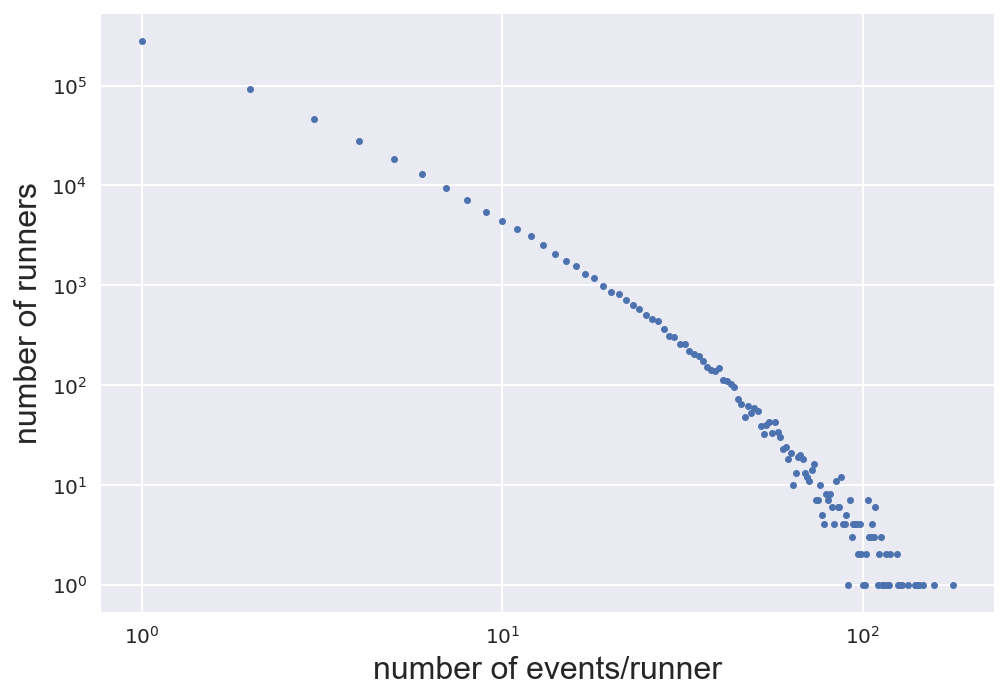

In [9]:
plt.loglog(full_df.UserID.value_counts().value_counts(),marker='.',linestyle='')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of events/runner',size=16)
plt.ylabel('number of runners',size=16);

### summary of distances popularity 

We have to select few distances, as of course it doens't make sense to compare performance (time) on different distances.  
It makes sense to choose __only 10/21/42 Km__, giving the number of participants.

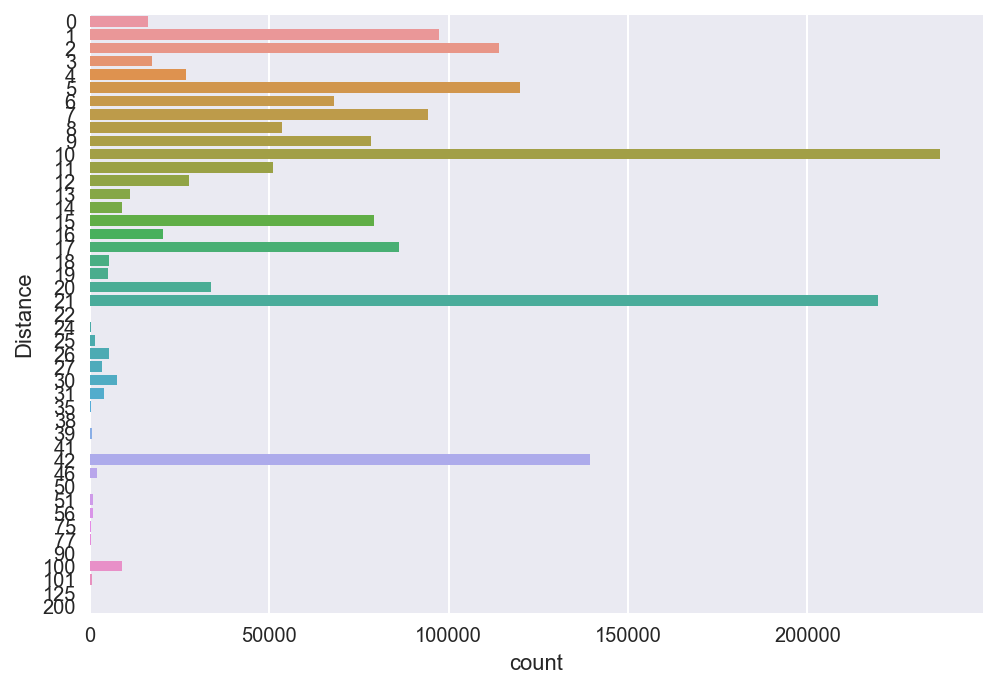

In [37]:
sns.countplot(y=full_df.Distance);

### only marathon runners
(we make copy of the full dataset, sub-setting the records for 42 Km)

### only semi-marathon runners
(we make copy of the full dataset, sub-setting the records for 21 Km )

In [65]:
marathon_full = full_df[full_df.Distance==42]
print(marathon_full.shape)
print('number of unique runners:', marathon_full.UserID.nunique())

(139271, 8)
number of unique runners: 68480


In [66]:
semi_marathon_full = full_df[full_df.Distance==21]
print(semi_marathon_full.shape)
print('number of unique runners:', semi_marathon_full.UserID.nunique())

(219744, 8)
number of unique runners: 106636


distribution of events/runner for marathon

distribution of events/runner for semi-marathon

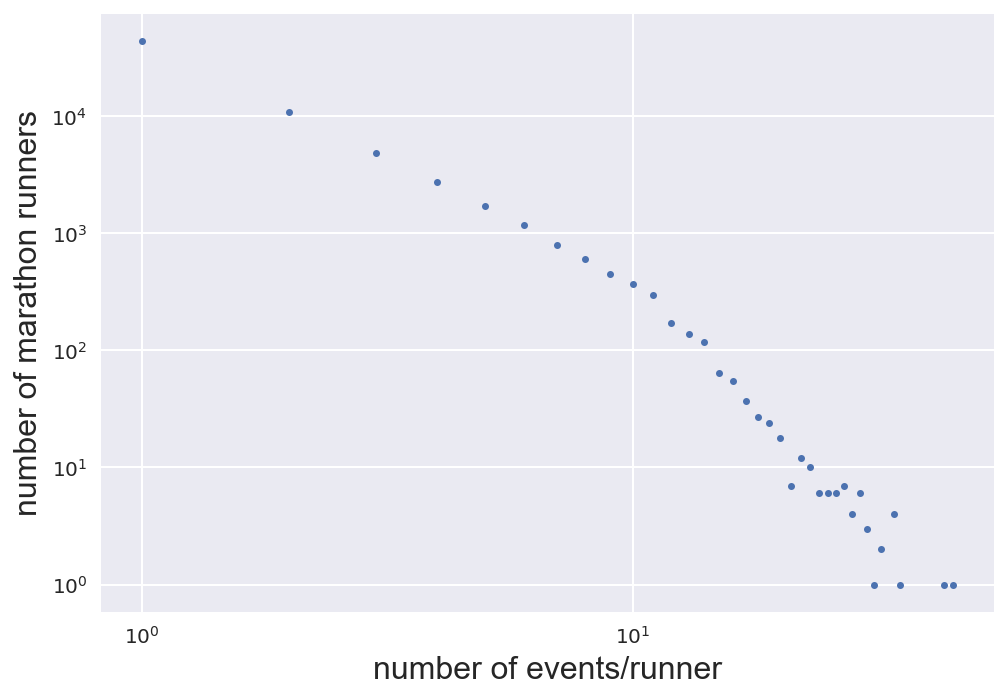

In [105]:
plt.loglog(marathon_full.UserID.value_counts().value_counts(),marker='.',linestyle='')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of events/runner',size=16)
plt.ylabel('number of marathon runners',size=16);

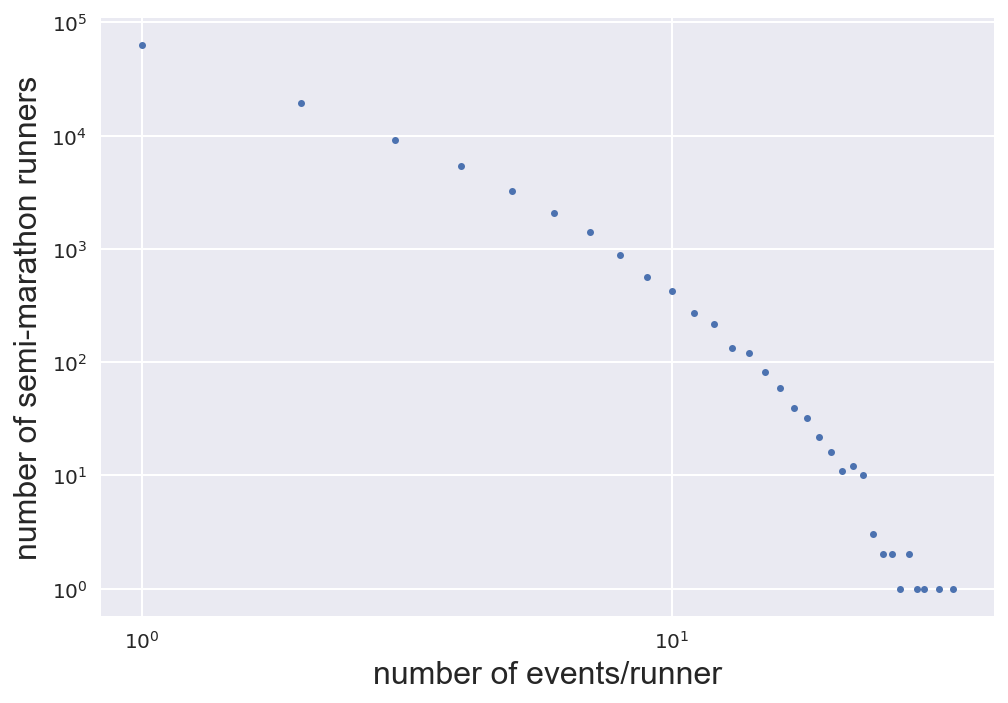

In [106]:
plt.loglog(semi_marathon_full.UserID.value_counts().value_counts(),marker='.',linestyle='')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of events/runner',size=16)
plt.ylabel('number of semi-marathon runners',size=16);

In [67]:
# here we can set the LOWER cut-off we want 
tau = 10

marathon_users_by_activity = marathon_full.UserID.value_counts()
active_users_marathon = marathon_users_by_activity[marathon_users_by_activity.values > tau]

print('number of marathon runners with more than',tau,'races:',
      len(active_users_marathon), '-',
      round(len(active_users_marathon) / len(marathon_users_by_activity) * 100, 2), '% of total')

number of marathon runners with more than 10 races: 1024 - 1.5 % of total


In [68]:
# here we can set the LOWER cut-off we want 
tau = 10

semima_users_by_activity = semi_marathon_full.UserID.value_counts()
active_users_semima = semima_users_by_activity[semima_users_by_activity.values > tau]

print('number of semi-marathon runners with more than',tau,'races:',
      len(active_users_semima), '-',
      round(len(active_users_semima) / len(semima_users_by_activity) * 100, 2), '% of total')

number of semi-marathon runners with more than 10 races: 1037 - 0.97 % of total


### only 10 Km runners
(we make copy of the full dataset, sub-setting the records for 21 Km )

In [69]:
ten_km_df = full_df[full_df.Distance==10]

print(ten_km_df.shape)
print('number of unique runners:', ten_km_df.UserID.nunique())

(236945, 8)
number of unique runners: 119283


distribution of events/runner for 10 Km

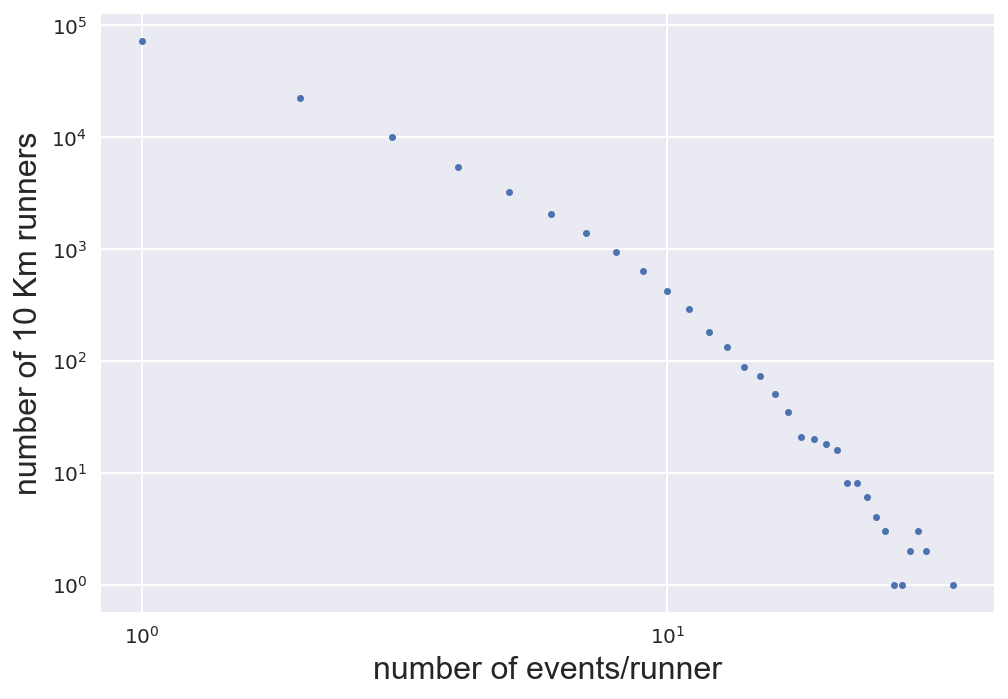

In [25]:
plt.loglog(ten_km_df.UserID.value_counts().value_counts(),marker='.',linestyle='')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of events/runner',size=16)
plt.ylabel('number of 10 Km runners',size=16);

In [70]:
# here we can set the LOWER cut-off we want 
tau = 10

tenkm_users_by_activity = ten_km_df.UserID.value_counts()
active_users_ten_km = tenkm_users_by_activity[tenkm_users_by_activity.values > tau]

print('number of marathon runners with more than',tau,'races:',
      len(active_users_ten_km), '-',
      round(len(active_users_ten_km) / len(tenkm_users_by_activity) * 100, 2), '% of total')

number of marathon runners with more than 10 races: 960 - 0.8 % of total


preparing time-series for 10 Km

# Clustering of time-series

How do we tackle this problem in general?   
The 2nd answer in [this post](http://stats.stackexchange.com/questions/66027/time-series-classification-very-poor-results)
on cross-validated mention to type of approaches.    

Given that _we don't know which are pro and non-pro runners_, we have to use an _unsupervised learning_  approach, like for instance
the one based on _hierarchical clustering_, described in 
[this other post](http://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas).

([this post](http://stats.stackexchange.com/questions/172439/comparing-clustering-time-series-with-unequal-lengths) might be also useful) 

Mind that in our case we have __unevenly space  time-series__ and this makes the problem harder.
More advanced techniques are collected in 
[this CV post](http://stats.stackexchange.com/questions/109343/dynamic-time-warping-for-irregular-time-series)

## exploration of ts
(this is a naive exploration, inspired by the
[correlation dimension](https://en.wikipedia.org/wiki/Correlation_dimension) - for a python implementation see
[this package](https://pypi.python.org/pypi/nolds/0.1.1))

In [71]:
ten_km_grouped =  ten_km_df.sort_values('Date').groupby('UserID')

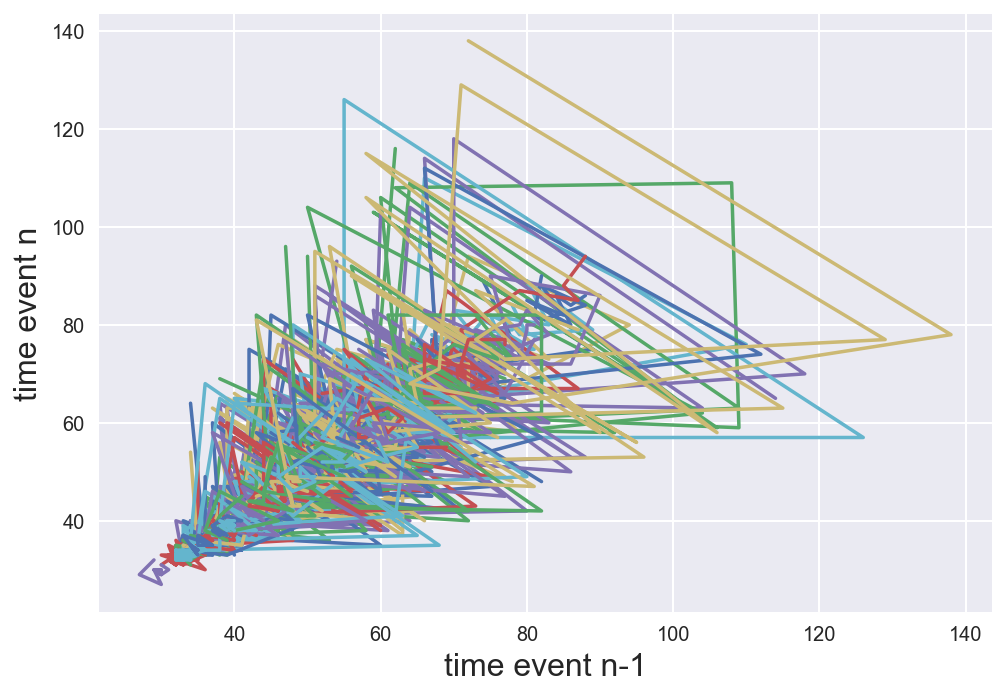

In [73]:
for n in active_users_ten_km.keys():

    n_ts = ten_km_grouped.get_group(n).Time

    plt.plot(n_ts[:len(n_ts)-1],n_ts[1:(len(n_ts))],label=n)
   

plt.xlabel('time event n-1',size=16)
plt.ylabel('time event n',size=16);
# plt.legend();

## define DTW distance 

( credits to the author of
this [nice notebook](http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb)
)

In [74]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

## DTW for 10 Km time-series 

In [85]:
# define distance matrix

num_comb = int(len(active_users_ten_km)*(len(active_users_ten_km)-1)/2)

# dist_mat = np.empty([num_comb,num_comb])
dist_mat = np.empty([10,10]) # dist matrix for 5 runners!

In [76]:
# need to map names ---> number: we need a dict for runners

runners_dict = dict.fromkeys(active_users_ten_km.keys()[:5])

for n,k in enumerate(runners_dict.keys()):
    
    runners_dict[k] = n

In [86]:
for c in itt.combinations(active_users_ten_km.keys()[:5],2):

    s0 = ten_km_grouped.get_group(c[0]).Time
    s1 = ten_km_grouped.get_group(c[1]).Time
    
    dist_mat[runners_dict[c[1]],runners_dict[c[0]]] = \
    dist_mat[runners_dict[c[0]],runners_dict[c[1]]] = \
    round(DTWDistance(s0.values,s1.values),2)
    
#     print('ditance between ts of',c[0],'and',c[1],':',DTWDistance(s0.values,s1.values))

please, consider 
[this post](http://stackoverflow.com/questions/41416498/dendrogram-or-other-plot-from-distance-matrix) 
to use __custom__ distance for dendrogram 

In [81]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

for this plot, credits to 
[this post](http://stackoverflow.com/questions/41416498/dendrogram-or-other-plot-from-distance-matrix)

there is __still something wrong__ ....

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


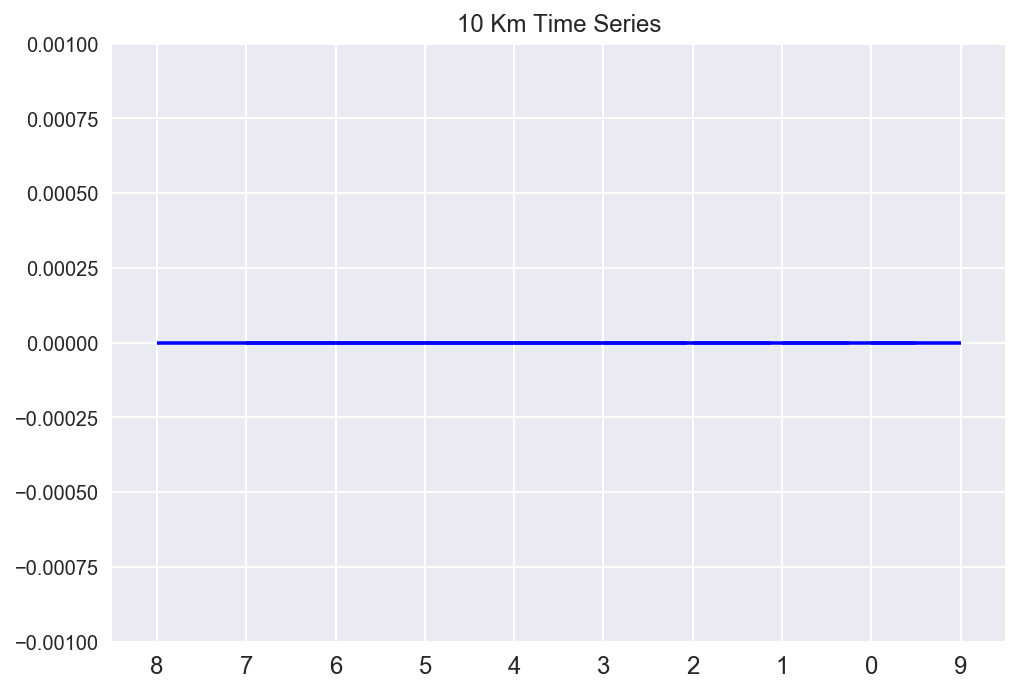

In [92]:
dists = squareform(dist_mat)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix) #, labels=["0", "1", "2"])
plt.title("10 Km Time Series")
plt.show()